# 2022-08-29 FD Verification

## Last time

* Discuss activity
* Measuring errors
* Stable discretizations

## Today
* Solutions and matrix properties
* Arbitrary order discretization
* Method of manufactured solutions
* Techniques for boundary conditions
* Extra: Fourier analysis of stencils

## Reading for next time

[Journal of Fluids Engineering: Editorial Policy Statement on the Control of Numerical Accuracy (1986)](https://jedbrown.org/files/RoacheGhiaWhite-JFEEditorialPolicyStatementControlOfNumericalAccuracy-1986.pdf)

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra

diff1l(x, u) = x[2:end],   (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1r(x, u) = x[1:end-1], (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1c(x, u) = x[2:end-1], (u[3:end] - u[1:end-2]) ./ (x[3:end] - x[1:end-2])

function refinement_error(f, fprime, d)
    error = []
    for n in grids
        x = LinRange(-3, 3, n)
        xx, yy = d(x, f.(x))
        push!(error, norm(yy - fprime.(xx), 1)/n)
    end
    error
end

refinement_error (generic function with 1 method)

# Consistency + Stability = Convergence

## Consistency

* When we apply the differential operator to the exact solution, we get a small residual.
* The residual converges under grid refinement.
* Hopefully fast as $h \to 0$

## Stability

* There do not exist "bad" functions that also satisfy the equation.
* This gets subtle for problems like incompressible flow.



# Second derivatives

We can compute a second derivative by applying first derivatives twice.

In [2]:
function diff2a(x, u)
    xx, yy = diff1c(x, u)
    diff1c(xx, yy)
end

function diff2b(x, u)
    xx, yy = diff1l(x, u)
    diff1r(xx, yy)
end

diff2list = [diff2a, diff2b]
n = 10
x = LinRange(-3, 3, n)
u = - cos.(x);

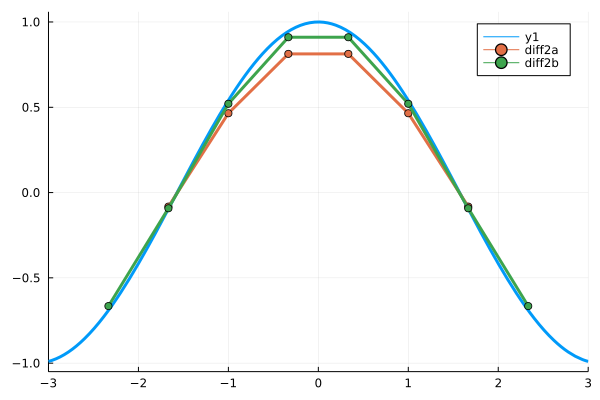

In [3]:
fig = plot(cos, xlims=(-3, 3))
for d2 in diff2list
    xx, yy = d2(x, u)
    plot!(fig, xx, yy, marker=:circle, label=d2)
end
fig

# How fast do these approximations converge?

In [4]:
grids = 2 .^ (3:10)
hs = 1 ./ grids
function refinement_error2(f, f_xx, d2)
    error = []
    for n in grids
        x = LinRange(-3, 3, n)
        xx, yy = d2(x, f.(x))
        push!(error, norm(yy - f_xx.(xx), Inf))
    end
    error
end

refinement_error2 (generic function with 1 method)

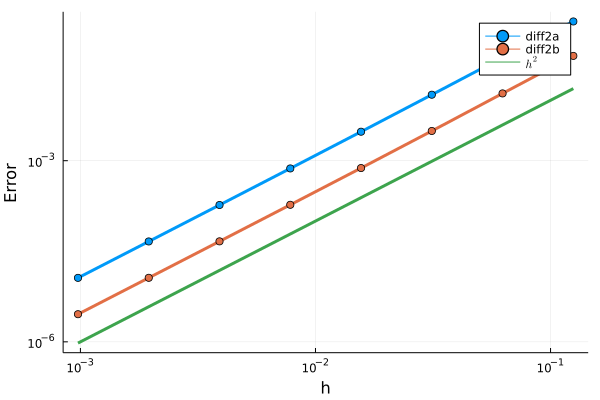

In [5]:
fig = plot(xlabel="h", xscale=:log10, ylabel="Error", yscale=:log10)
for d2 in diff2list
    error = refinement_error2(x -> -cos(x), cos, d2)
    plot!(fig, hs, error, marker=:circle, label=d2)
end
plot!(fig, hs, hs .^ 2, label="\$h^2\$") 

* Both methods are second order accurate.
* The `diff2b` method is more accurate than `diff2a` (by a factor of 4)
* The `diff2b` method can't compute derivatives at points adjacent the boundary.
* We don't know yet whether either is stable

# Differentiation matrices

All our `diff*` functions thus far have been linear in `u`, therefore they can be represented as matrices.
$$\frac{u_{i+1} - u_i}{x_{i+1} - x_i} = \begin{bmatrix} -1/h & 1/h \end{bmatrix} \begin{bmatrix} u_i \\ u_{i+1} \end{bmatrix}$$

In [6]:
function diff1_mat(x)
    n = length(x)
    D = zeros(n, n)
    h = x[2] - x[1]
    D[1, 1:2] = [-1/h  1/h]
    for i in 2:n-1
        D[i, i-1:i+1] = [-1/2h  0  1/2h]
    end
    D[n, n-1:n] = [-1/h  1/h]
    D
end
x = LinRange(-1, 1, 5)
diff1_mat(x)

5×5 Matrix{Float64}:
 -2.0   2.0   0.0   0.0  0.0
 -1.0   0.0   1.0   0.0  0.0
  0.0  -1.0   0.0   1.0  0.0
  0.0   0.0  -1.0   0.0  1.0
  0.0   0.0   0.0  -2.0  2.0

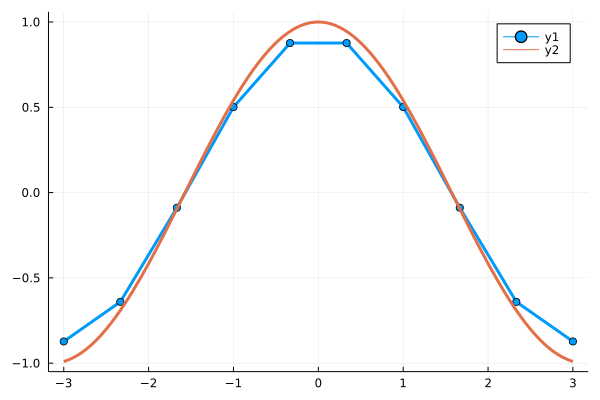

In [7]:
x = LinRange(-3, 3, 10)
plot(x, diff1_mat(x) * sin.(x), marker=:circle)
plot!(cos)

# How accurate is this derivative matrix?

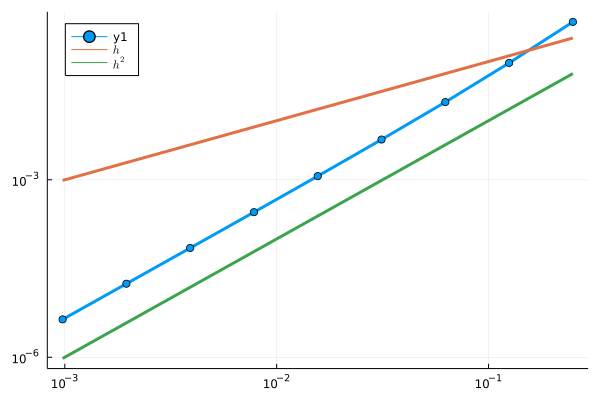

In [8]:
grids = 2 .^ (2:10); hs = 1 ./ grids
fig = plot(xscale=:log10, yscale=:log10, legend=:topleft)
error = refinement_error(sin, cos, (x, u) -> (x, diff1_mat(x) * u))
plot!(fig, hs, error, marker=:circle)
plot!(fig, hs, hs, label="\$h\$")
plot!(fig, hs, hs .^ 2, label="\$h^2\$")

# Can we study it as a matrix?

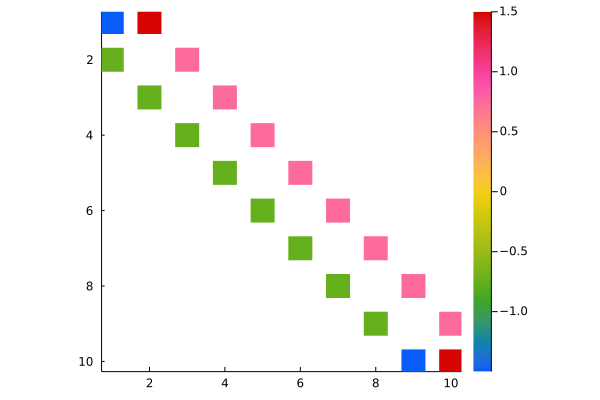

In [9]:
function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

D = diff1_mat(x)
my_spy(D)

In [10]:
eigvals(D)

10-element Vector{ComplexF64}:
   -7.219363424932637e-8 + 0.0im
 -1.0787811616230769e-14 - 0.26047226650040234im
 -1.0787811616230769e-14 + 0.26047226650040234im
  -1.942890293094024e-16 - 1.1490666646784673im
  -1.942890293094024e-16 + 1.1490666646784673im
  3.3306690738754696e-16 - 1.4095389311788624im
  3.3306690738754696e-16 + 1.4095389311788624im
  3.7470027081099033e-16 - 0.750000000000001im
  3.7470027081099033e-16 + 0.750000000000001im
    7.219365506018768e-8 + 0.0im

# Second derivative with Dirichlet boundary conditions

The left endpoint in our example boundary value problem has a Dirichlet boundary condition,
$$u(-1) = a . $$
With finite difference methods, we have an explicit degree of freedom $u_1 = u(x_1 = -1)$ at that endpoint.
When building a matrix system for the BVP, we can implement this boundary condition by modifying the first row of the matrix,
$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{2:,:} & & \\ \\ \end{bmatrix} \begin{bmatrix} u_1 \\ \\ u_{2:} \\ \\ \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{2:} \\ \\ \end{bmatrix} . $$

* This matrix is not symmetric even if $A$ is.

In [11]:
function laplacian_dirichlet(x)
    n = length(x)
    D = zeros(n, n)
    h = x[2] - x[1]
    D[1, 1] = 1
    for i in 2:n-1
        D[i, i-1:i+1] = (1/h^2) * [-1, 2, -1]
    end
    D[n, n] = 1
    D
end

laplacian_dirichlet (generic function with 1 method)

# Laplacian as a matrix

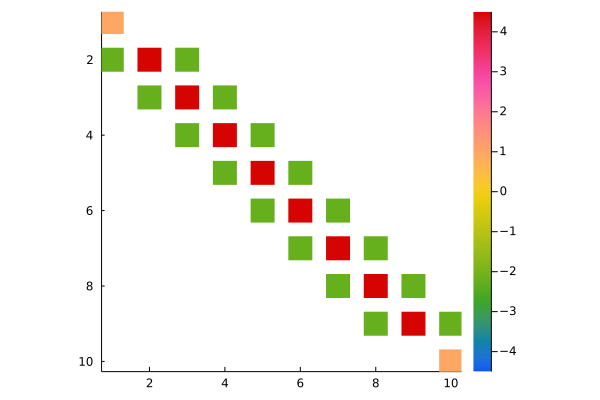

In [12]:
L = laplacian_dirichlet(x)
my_spy(L)

In [13]:
@show cond(L)
eigvals(L)

cond(L) = 36.5545720479542


10-element Vector{Float64}:
 0.27138320646341163
 1.0
 1.0
 1.052800005964599
 2.250000000000001
 3.7185832004988066
 5.281416799501184
 6.749999999999994
 7.947199994035395
 8.728616793536574

# Solutions

$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{2:n-1,:} & & \\ \\ \\ 0&0 &0 &0 &0 & 1 \end{bmatrix} \begin{bmatrix} u_1 \\ \\ u_{2:n-1} \\ \\ \\ u_n \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{2:n-1} \\ \\ \\ b \end{bmatrix} . $$

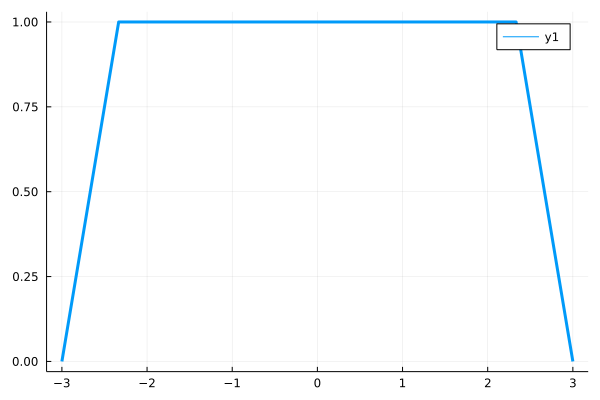

In [14]:
L = laplacian_dirichlet(x)
f = one.(x)
f[1] = 0
f[end] = 0;
plot(x, f)

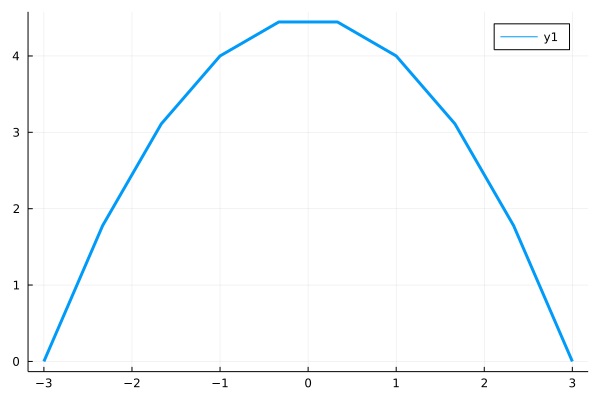

In [15]:
u = L \ f
plot(x, u)

# Discrete "Green's functions"

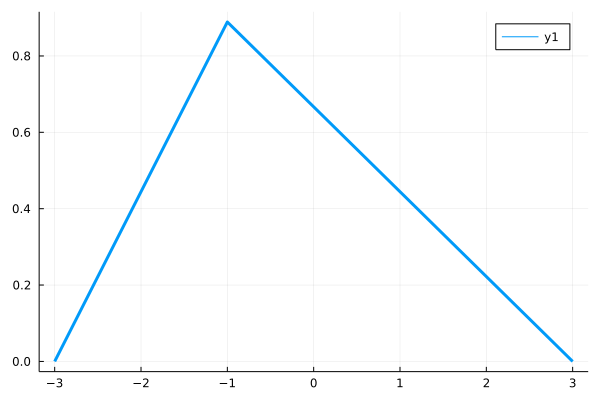

In [16]:
plot(x, inv(L)[:, 4])

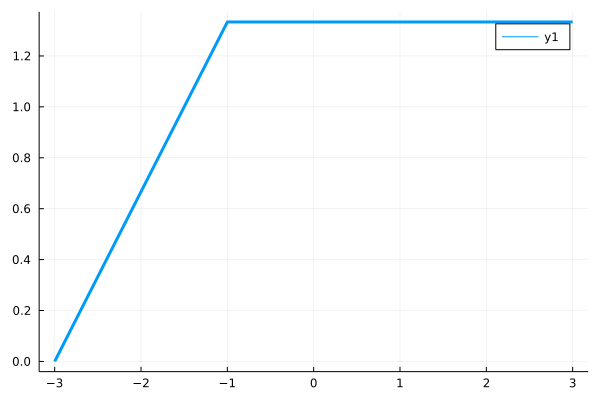

In [17]:
Ln = copy(L)
Ln[n, n-1] = -1
plot(x, inv(Ln)[:, 4])

# Discrete eigenfunctions

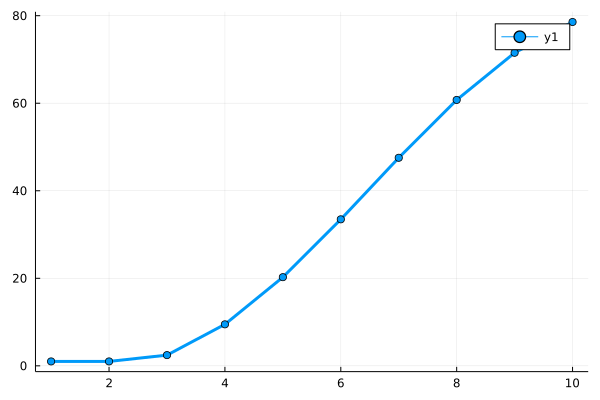

In [18]:
x = LinRange(-1, 1, 10)
L = laplacian_dirichlet(x)
Lambda, V = eigen(L)
plot(Lambda, marker=:circle)

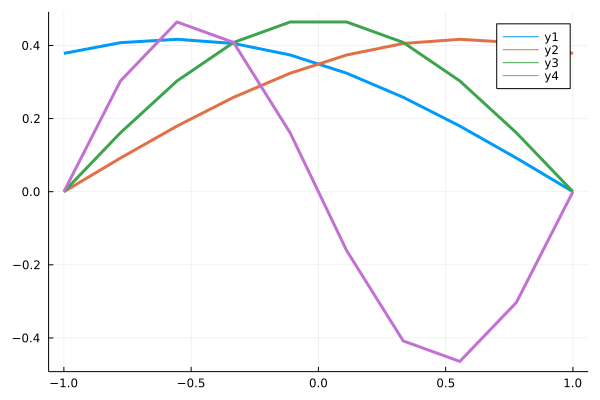

In [19]:
plot(x, V[:, 1:4])

# Outlook on our method

## Pros

* Consistent
* Stable
* Second order accurate (we hope)

## Cons

* Only second order accurate (at best)
* Worse than second order on non-uniform grids
* Worse than second order at Neumann boundaries
* Boundary conditions break symmetry

# Interpolation by Vandermonde matrices

We can compute a polynomial

$$ p(x) = c_0 + c_1 x + c_2 x^2 + \dotsb $$

that assumes function values $p(x_i) = u_i$ by solving a linear system with the Vandermonde matrix.

$$ \underbrace{\begin{bmatrix} 1 & x_0 & x_0^2 & \dotsb \\
    1 & x_1 & x_1^2 & \dotsb \\
    1 & x_2 & x_2^2 & \dotsb \\
    \vdots & & & \ddots \end{bmatrix}}_V \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \end{bmatrix} = \begin{bmatrix} u_0 \\ u_1 \\ u_2 \\ \vdots \end{bmatrix} .$$

In [20]:
function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

In [21]:
vander(LinRange(-1, 1, 5))

5×5 Matrix{Float64}:
 1.0  -1.0  1.0   -1.0    1.0
 1.0  -0.5  0.25  -0.125  0.0625
 1.0   0.0  0.0    0.0    0.0
 1.0   0.5  0.25   0.125  0.0625
 1.0   1.0  1.0    1.0    1.0

# Fitting a polynomial

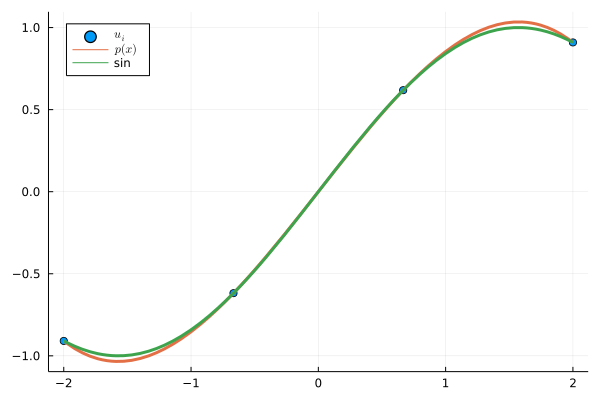

In [22]:
k = 4
x = LinRange(-2, 2, k)
u = sin.(x)
V = vander(x)
c = V \ u
scatter(x, u, label="\$u_i\$", legend=:topleft)
plot!(x -> (vander(x, k) * c)[1,1], label="\$p(x)\$")
plot!(sin, label=sin)

# Differentiating

We're given the coefficients $c = V^{-1} u$ of the polynomial
$$p(x) = c_0 + c_1 x + c_2 x^2 + \dotsb.$$
What is
\begin{align} p(0) &= c_0 \\
p'(0) &= c_1 \\ 
p''(0) &= c_2 \cdot 2\\
p^{(k)}(0) &= c_k \cdot k! .
\end{align}

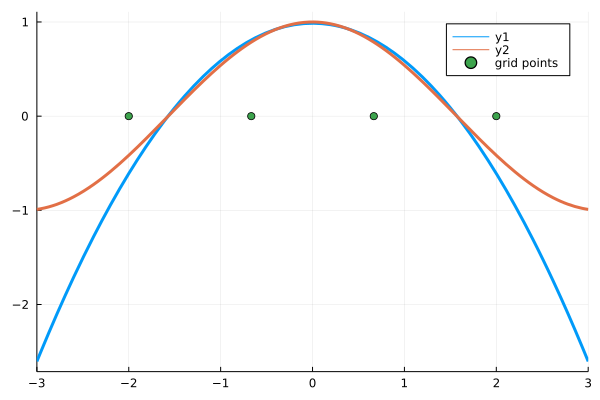

In [23]:
function fdstencil1(source, target)
    "first derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    inv(V)[2, :]' # as a row vector
end
plot([z -> fdstencil1(x, z) * u, cos], xlims=(-3,3))
scatter!(x, 0*x, label="grid points")

# Arbitrary order

In [24]:
function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end
fdstencil(x, 0.5, 2)


1×4 adjoint(::Vector{Float64}) with eltype Float64:
 0.0703125  0.351563  -0.914062  0.492187

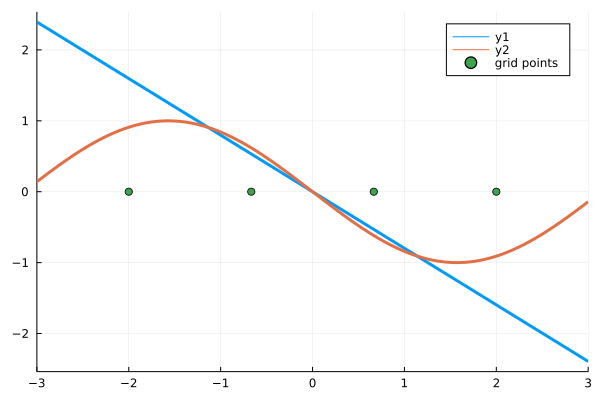

In [25]:
plot([z -> fdstencil(x, z, 2) * u,
        z -> -sin(z)], xlim=(-3, 3)) 
scatter!(x, 0*x, label="grid points")

## We didn't call `inv(V)`; what's up?
$$p(0) = s_0^0 u_0 + s_1^0 u_1 + s_2^0 u_2 + \dotsb = e_0^T \underbrace{V^{-1} u}_c = \underbrace{e_0^T V^{-1}}_{s^0} u$$

# Convergence order

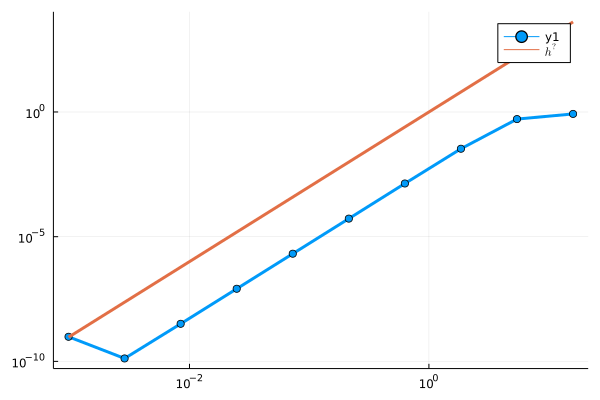

In [26]:
hs = 2 .^ -LinRange(-4, 10, 10)
function diff_error(u, du, h; n, k, z=0)
    x = LinRange(-h, h, n) .+ .5
    fdstencil(x, z, k) * u.(x) - du.(z)
end
errors = [diff_error(sin, t -> -sin(t), h, n=5, k=2, z=.5+0.1*h)
    for h in hs]
plot(hs, abs.(errors), marker=:circle)
plot!(h -> h^3, label="\$h^?\$", xscale=:log10, yscale=:log10)

## Observations

* When using $n=3$ points, we fit a polynomial of degree 2 and have error $O(h^3)$ for interpolation $p(0)$.
* Each derivative gives up one order of accuracy in general.
* Centered diff on uniform grids can have extra cancellation (superconvergence)
* The Vandermonde matrix is notoriously ill-conditioned with many points $n$. We recommend using a [stable algorithm from Fornberg](https://doi.org/10.1137/S0036144596322507).

# High order discretization of the Laplacian
## The Poisson problem $-u_{xx} = f$ with boundary conditions

In [27]:
function poisson(x, spoints, forcing; left=(0, zero), right=(0, zero))
    n = length(x)
    L = zeros(n, n)
    rhs = forcing.(x)
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        L[i, js] = -fdstencil(x[js], x[i], 2)
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], left[1])
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], right[1])
    rhs[1] = left[2](x[1])
    rhs[n] = right[2](x[n])
    L, rhs
end

poisson (generic function with 1 method)

In [28]:
L, b = poisson(LinRange(-1, 1, 6), 3, zero, left=(1, zero))
L

6×6 Matrix{Float64}:
 -3.75   5.0   -1.25   0.0    0.0    0.0
 -6.25  12.5   -6.25   0.0    0.0    0.0
  0.0   -6.25  12.5   -6.25   0.0    0.0
  0.0    0.0   -6.25  12.5   -6.25   0.0
  0.0    0.0    0.0   -6.25  12.5   -6.25
  0.0    0.0    0.0    0.0   -0.0    1.0

# Method of manufactured solutions

## Problem: analytic solutions to PDEs are hard to find

Let's choose a smooth function with rich derivatives,
$$ u(x) = \tanh(x) . $$
Then $$ u'(x) = \cosh^{-2}(x) $$ and $$ u''(x) = -2 \tanh(x) \cosh^{-2}(x) . $$

* This works for nonlinear too.

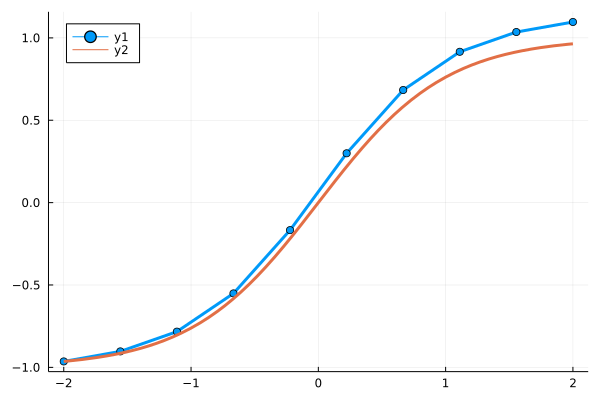

In [29]:
x = LinRange(-2, 2, 10)
L, rhs = poisson(x, 3,
    x -> 2 * tanh(x) / cosh(x)^2,
    left=(0, tanh), 
    right=(1, x -> cosh(x)^-2))
u = L \ rhs
plot(x, u, marker=:circle, legend=:topleft)
plot!(tanh)

# Convergence rate

In [30]:
ns = 2 .^ (2:10)
hs = 1 ./ ns
function poisson_error(n; spoints=3)
    x = LinRange(-2, 2, n)
    L, rhs = poisson(x, spoints, x -> 2 * tanh(x) / cosh(x)^2,
        left = (0, tanh),
        right = (1, x -> cosh(x)^-2))
    u = L \ rhs
    norm(u - tanh.(x), Inf)
end

poisson_error (generic function with 1 method)

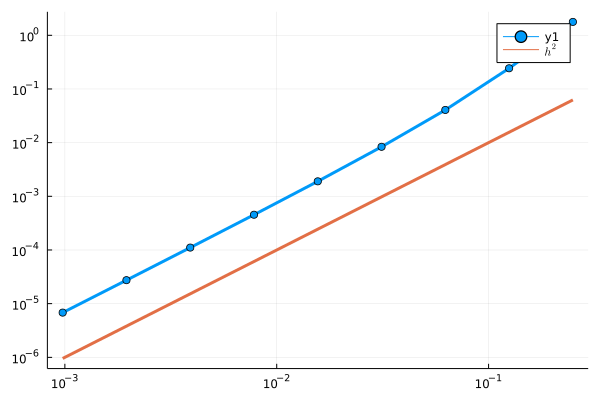

In [31]:
plot(hs, [poisson_error(n, spoints=3) for n in ns], marker=:circle)
plot!(h -> h^2, label="\$h^2\$", xscale=:log10, yscale=:log10)

# Symmetry in boundary conditions: Dirichlet

We have implemented Dirichlet conditions by modifying the first row of the matrix,
$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{1:,:} & & \\ \\ \end{bmatrix} \begin{bmatrix} u_0 \\ \\ u_{1:} \\ \\ \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{1:} \\ \\ \end{bmatrix} . $$

* This matrix is not symmetric even if $A$ is.
* We can eliminate $u_0$ and create a reduced system for $u_{1:}$.
* Generalize: consider a $2\times 2$ block system
$$ \begin{bmatrix} I & 0 \\ A_{10} & A_{11} \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \end{bmatrix} = \begin{bmatrix} f_0 \\ f_1 \end{bmatrix} .$$

We can rearrange as
$$ A_{11} u_1 = f_1 - A_{10} f_0, $$
which is symmetric if $A_{11}$ is.
* This is called "lifting" and is often done implicitly in the mathematics literature.  It is convenient for linear solvers and eigenvalue solvers, but inconvenient for IO and postprocessing, as well as some nonlinear problems.
* Convenient alternative: write
$$ \begin{bmatrix} I & 0 \\ 0 & A_{11} \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \end{bmatrix} = \begin{bmatrix} f_0 \\ f_1 - A_{10} f_0 \end{bmatrix}, $$
which is symmetric and decouples the degrees of freedom associated with the boundary. This method applies cleanly to nonlinear problems.
* Optionally scale the identity by some scalar related to the norm of $A_{11}$.

# Symmetry in boundary conditions: Neumann

Consider FD discretization of the Neumann boundary condition
$$ \frac{du}{dx}(1) = b . $$
1. Use a one-sided difference formula as in
$$ \frac{u_n - u_{n-1}}{h} = b . $$
  * an extra discretization choice
  * may reduce order of accuracy compared to interior discretization, lose symmetry.
2. Temporarily introduce a ghost value $u_{n+1} = u(x_{n+1} = 1 + h)$ (possibly more) and define it to be a reflection of the values from inside the domain.  In the case $b=0$, this reflection is $u_{n+i} = u_{n-i}$.  More generally,
$$ u_{n+i} = u_{n-i} + 2b(x_n - x_{n-i}) . $$

After this definition of ghost values, we apply the interior discretization at the boundary. For our reference equation, we would write

$$ \frac{-u_{n-1} + 2 u_n - u_{n+1}}{h^2} = f(x_n) $$

which simplifies to $$ \frac{u_n - u_{n-1}}{h^2} = f(x_n)/2 + b/h $$
after dividing by 2 and moving the boundary term to the right hand side.

# Fourier analysis of stencils

Consider the plane waves $\phi(x, \theta) = e^{i\theta x}$.

Sample $\phi$ on a discrete grid $x = \mathbb Z$ and apply the stencil
\begin{align}
S \phi(x, \theta) &= s_{-1} \phi(x-1, \theta) + s_{0} \phi(x, \theta) + s_1 \phi(x+1,\theta) \\
&= \Big( s_{-1} e^{-i\theta} + s_0 + s_{1} e^{i\theta} \Big) \phi(x, \theta)
\end{align}
With $S = \begin{bmatrix} -1 & 2 & -1 \end{bmatrix}$, we get
$$S \phi(x, \theta) = \underbrace{(2 - 2 \cos\theta)}_{\hat S(\theta)} \phi(x, \theta)$$
We call $\hat S(\theta)$ the *symbol* of the operator.
What is the symbol of the continuous second derivative?

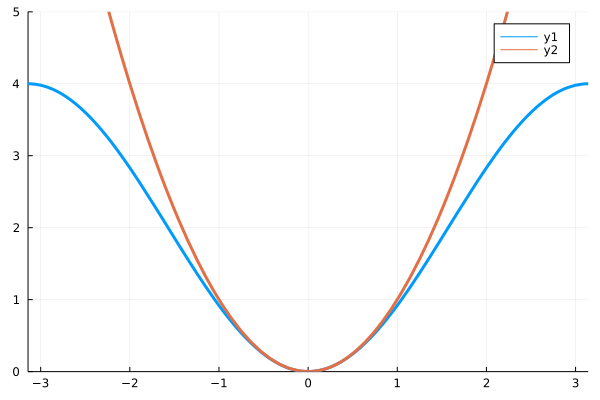

In [32]:
plot([theta -> 2 - 2*cos(theta),
        theta -> theta^2],
    xlims=(-pi, pi), ylim=(0, 5))